In [58]:
import os
os.chdir("/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir")
from load_data import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct
import pandas as pd
import numpy as np
import mpu
import matplotlib.pyplot as plt
import scipy.stats as st

In [8]:
wrangler = Wrangler()
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)

# remove extreme prices
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
filter = price < 500
listings = listings[filter]

listings, y = wrangler.fit_listings(listings, standardize = False)

------------------------------
Fit listings...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
61 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra_pillows_and_blankets', 'Luggage_dropoff_allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'host_location_country_Ireland', 'neighbourhood_cleansed_Dn_Laoghaire-Rathdown']


In [10]:
y = y/listings["accommodates"].values

Latitude and Longitude of Dublin City Center according to Google

In [11]:
dublin_cc = np.array([53.344053017257245, -6.267026698067987])

# Gaussian Process Regression

In [12]:
X = listings[["latitude", "longitude"]].values

In [13]:
def distance(a, b=dublin_cc):
    return mpu.haversine_distance(a, b)

In [14]:
X_dist = np.apply_along_axis(distance,1,X)

In [15]:
data = np.vstack((y,X_dist)).T
data = data[data[:, 1].argsort()]

y = data[:,0]
X = data[:,1].reshape(-1,1)

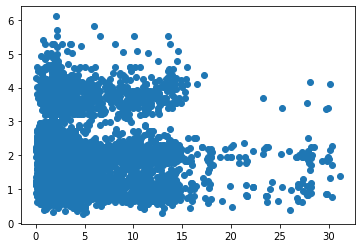

In [16]:
plt.scatter(X, y)

In [74]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=500, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
mask = np.ones(X.shape[0], dtype=bool)
mask[training_indices] = False
X_test = X[mask]


In [75]:
kernel = 1*RBF(length_scale = 0.001) + 1 * RBF(length_scale=2) * 1 * DotProduct() + 1 * ConstantKernel()
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

0.944**2 * RBF(length_scale=1.19e-05) + 1.16**2 * RBF(length_scale=1.65e-05) * 0.0235**2 * DotProduct(sigma_0=0.00866) + 0.731**2 * 2.77**2

Text(0, 0.5, 'Pred. log Price per Accommodates')

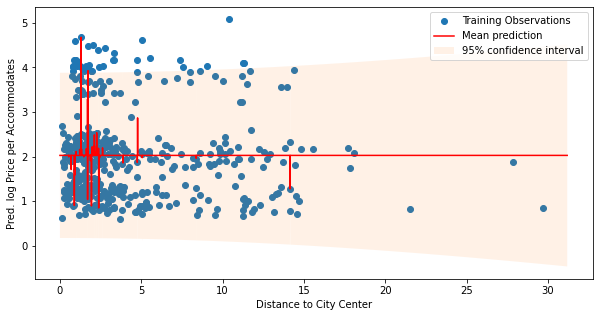

In [76]:
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(X_train, y_train, label="Training Observations")
ax.plot(X_test, mean_prediction, label="Mean prediction", color = "red")
ax.fill_between(
    X_test.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.1,
    label=r"95% confidence interval",
)
ax.legend()
ax.set_xlabel("Distance to City Center")
ax.set_ylabel("Pred. log Price per Accommodates")
#_ = ax.title("Gaussian process regression")

No findings

Does the direction matter?

In [171]:
X1 = X[:,0]-dublin_cc[0]
X2 = X[:,1]-dublin_cc[1]
X = np.vstack((X1, X2)).T

In [173]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=10, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

Learned kernel 2.17**2 * RBF(length_scale=0.0238)


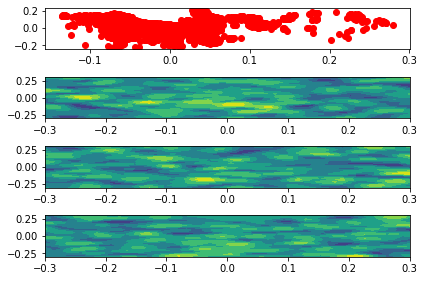

In [180]:
# Grid
lim = 0.3
res = 50
lin = np.linspace(-lim, lim, res)

# x1.shape = (50, 50)
x1, x2 = np.meshgrid(lin, lin)
# xx.shape = (2500, 2)
xx = np.vstack((x1.flatten(), x2.flatten())).T


kernel = 1*RBF()
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=10)
gp.fit(X_train, y_train)
print("Learned kernel", gp.kernel_)
# y_mean.shape = (2500, )
# y_cov.shape = (2500, 2500)
y_mean, y_cov = gp.predict(xx, return_cov=True)

posterior_nums = 3
posteriors = st.multivariate_normal.rvs(mean=y_mean, cov=y_cov,
                                        size=posterior_nums)

fig, axs = plt.subplots(posterior_nums+1)

ax = axs[0]
#ax.contourf(x1, x2, y_analytic)
ax.plot(X[:, 0], X[:, 1], "r.", ms=12)

for i, post in enumerate(posteriors, 1):
    axs[i].contourf(x1, x2, post.reshape(-1, res))

plt.tight_layout()
plt.show()

Doesn't seem like it does